In [8]:
# 项目的 脚本 在 /root/GanLuo/ICML2025_project/scripts_pushpull/run_push_pull_track_grad_norm.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

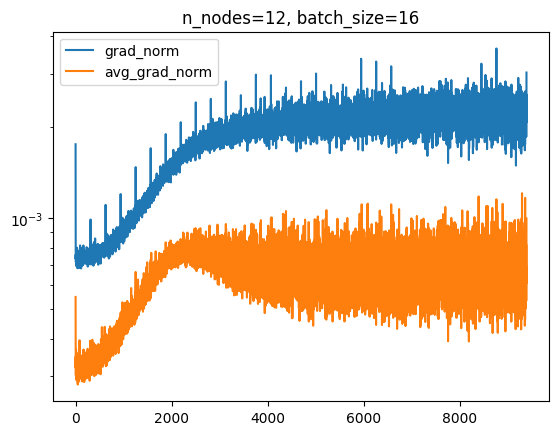

In [3]:
df4 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=12, batch_size=16, 2025-03-22.csv")
plt.semilogy(df4["grad_norm"], label="grad_norm")
plt.semilogy(df4["avg_grad_norm"], label="avg_grad_norm")
plt.title("n_nodes=12, batch_size=16")
plt.legend()
plt.show()

In [4]:
df1 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=2, batch_size=128, 2025-03-22.csv")
df2 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=4, batch_size=128, 2025-03-22.csv")
df3 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=8, batch_size=128, 2025-03-22.csv")
df4 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=16, batch_size=128, 2025-03-22.csv")

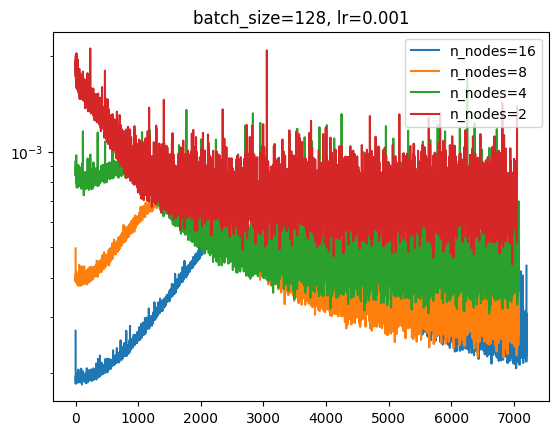

In [20]:
df1 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=2, batch_size=128, 2025-03-22.csv")
df2 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=4, batch_size=128, 2025-03-22.csv")
df3 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=8, batch_size=128, 2025-03-22.csv")
df4 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=16, batch_size=128, 2025-03-22.csv")
a = "avg_grad_norm"


plt.semilogy(df4[a], label="n_nodes=16")
plt.semilogy(df3[a], label="n_nodes=8")
plt.semilogy(df2[a], label="n_nodes=4")
plt.semilogy(df1[a], label="n_nodes=2")
plt.title("batch_size=128, lr=0.001")
plt.legend()
plt.show()

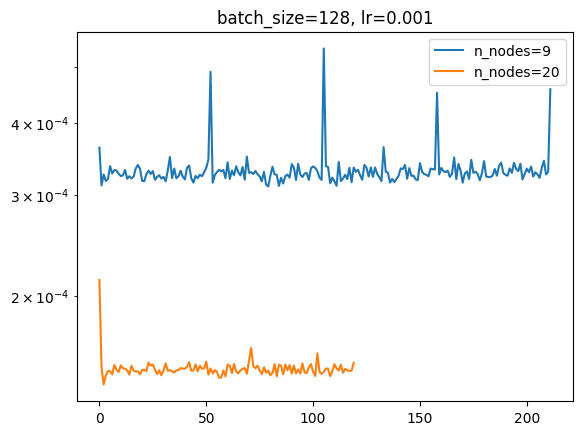

In [6]:
df1 = pd.read_csv("/root/GanLuo/ICML2025_project/PUSHPULL_PROJECT/real_data_track_grad_norm/output/grad_norm_TEST_Exp_test, PushPull, lr=0.001, n_nodes=9, batch_size=128, 2025-03-22.csv")
df2 = pd.read_csv("/root/GanLuo/ICML2025_project/PUSHPULL_PROJECT/real_data_track_grad_norm/output/grad_norm_TEST_Exp_test, PushPull, lr=0.001, n_nodes=20, batch_size=128, 2025-03-22.csv")

a = "avg_grad_norm"

plt.semilogy(df1[a], label="n_nodes=9")
plt.semilogy(df2[a], label="n_nodes=20")
plt.title("batch_size=128, lr=0.001")
plt.legend()
plt.show()

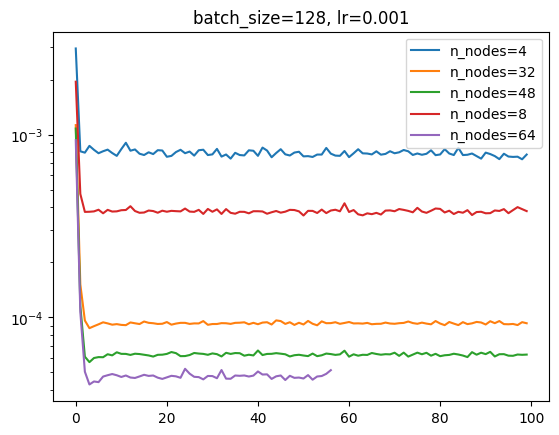

In [14]:
df1 = pd.read_csv("./new_output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=4, batch_size=128, 2025-03-23.csv")
df2 = pd.read_csv("./new_output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=32, batch_size=128, 2025-03-23.csv")
df3 = pd.read_csv("./new_output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=48, batch_size=128, 2025-03-23.csv")
df4 = pd.read_csv("./new_output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=8, batch_size=128, 2025-03-23.csv")
df5 = pd.read_csv("./new_output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=64, batch_size=128, 2025-03-23.csv")

a = "avg_grad_norm"
s = 100

plt.semilogy(df1[a][:s], label="n_nodes=4")
plt.semilogy(df2[a][:s], label="n_nodes=32")
plt.semilogy(df3[a][:s], label="n_nodes=48")
plt.semilogy(df4[a][:s], label="n_nodes=8")
plt.semilogy(df5[a][:s], label="n_nodes=64")
plt.title("batch_size=128, lr=0.001")
plt.legend()
plt.show()

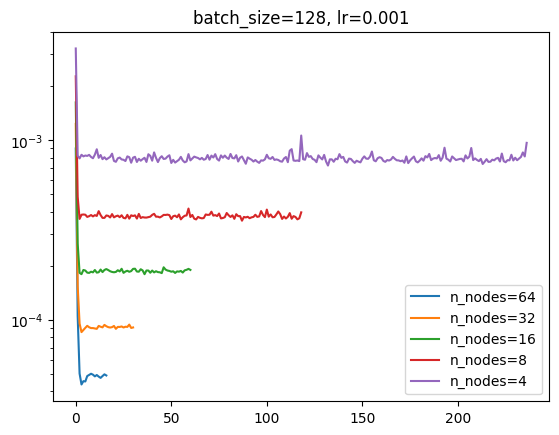

In [ ]:
df1 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=64, batch_size=128, 2025-03-23.csv")
df2 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=32, batch_size=128, 2025-03-23.csv")
df3 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=16, batch_size=128, 2025-03-23.csv")
df4 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=8, batch_size=128, 2025-03-23.csv")
df5 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=4, batch_size=128, 2025-03-23.csv")

a = "avg_grad_norm"
s = 500

plt.semilogy(df1[a][:s], label="n_nodes=64")
plt.semilogy(df2[a][:s], label="n_nodes=32")
plt.semilogy(df3[a][:s], label="n_nodes=16")
plt.semilogy(df4[a][:s], label="n_nodes=8")
plt.semilogy(df5[a][:s], label="n_nodes=4")

plt.title("batch_size=128, lr=0.001")
plt.legend()
plt.show()

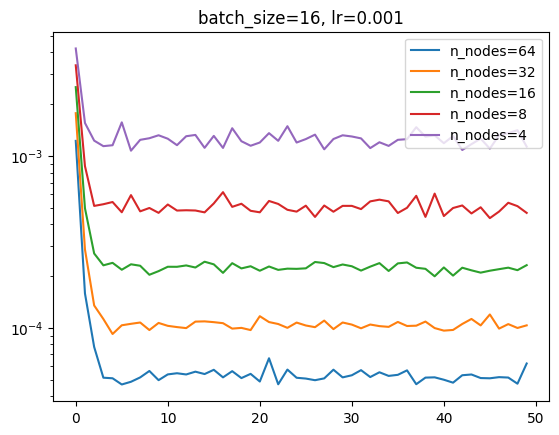

In [27]:
df1 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=64, batch_size=16, 2025-03-23.csv")
df2 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=32, batch_size=16, 2025-03-23.csv")
df3 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=16, batch_size=16, 2025-03-23.csv")
df4 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=8, batch_size=16, 2025-03-23.csv")
df5 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=4, batch_size=16, 2025-03-23.csv")

a = "avg_grad_norm"
s = 50

plt.semilogy(df1[a][:s], label="n_nodes=64")
plt.semilogy(df2[a][:s], label="n_nodes=32")
plt.semilogy(df3[a][:s], label="n_nodes=16")
plt.semilogy(df4[a][:s], label="n_nodes=8")
plt.semilogy(df5[a][:s], label="n_nodes=4")

plt.title("batch_size=16, lr=0.001")
plt.legend()
plt.show()

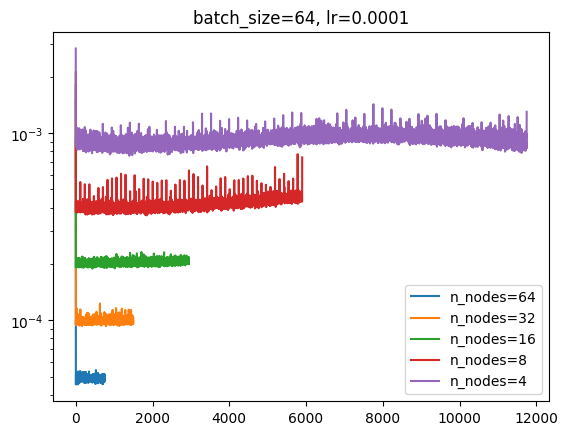

In [30]:
df1 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=64, batch_size=64, 2025-03-23.csv")
df2 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=32, batch_size=64, 2025-03-23.csv")
df3 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=16, batch_size=64, 2025-03-23.csv")
df4 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=8, batch_size=64, 2025-03-23.csv")
df5 = pd.read_csv("./nice/grad_norm_Exp_test, PushPull, lr=0.0001, n_nodes=4, batch_size=64, 2025-03-23.csv")

a = "avg_grad_norm"
s = 500000

plt.semilogy(df1[a][:s], label="n_nodes=64")
plt.semilogy(df2[a][:s], label="n_nodes=32")
plt.semilogy(df3[a][:s], label="n_nodes=16")
plt.semilogy(df4[a][:s], label="n_nodes=8")
plt.semilogy(df5[a][:s], label="n_nodes=4")

plt.title("batch_size=64, lr=0.0001")
plt.legend()
plt.show()

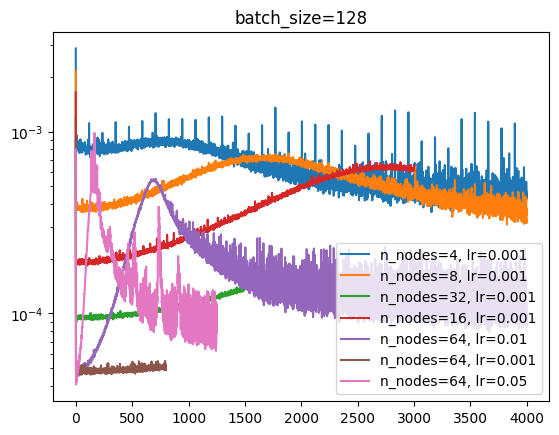

In [57]:
df1 = pd.read_csv("./out/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=64, batch_size=128, 2025-03-23.csv")
df2 = pd.read_csv("./out/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=32, batch_size=128, 2025-03-23.csv")
df3 = pd.read_csv("./out/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=16, batch_size=128, 2025-03-23.csv")
df4 = pd.read_csv("./out/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=8, batch_size=128, 2025-03-23.csv")
df5 = pd.read_csv("./out/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=4, batch_size=128, 2025-03-23.csv")
df11 = pd.read_csv("./out/grad_norm_Exp_test, PushPull, lr=0.01, n_nodes=64, batch_size=128, 2025-03-23.csv")
df111 = pd.read_csv("./out/grad_norm_Exp_test, PushPull, lr=0.05, n_nodes=64, batch_size=128, 2025-03-23.csv")


a = "avg_grad_norm"
s = 4000
plt.semilogy(df5[a][:s], label="n_nodes=4, lr=0.001")
plt.semilogy(df4[a][:s], label="n_nodes=8, lr=0.001")
plt.semilogy(df2[a][:s], label="n_nodes=32, lr=0.001")
plt.semilogy(df3[a][:s], label="n_nodes=16, lr=0.001")
plt.semilogy(df11[a][:s], label="n_nodes=64, lr=0.01")
plt.semilogy(df1[a][:s], label="n_nodes=64, lr=0.001")
plt.semilogy(df111[a][:1250], label="n_nodes=64, lr=0.05")


plt.title("batch_size=128")
plt.legend()
plt.show()